In [112]:
%%time
# for development, changes in other modules have to be reloaded to reflect changes
%load_ext autoreload
%autoreload 1

import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sbn 
import os, sys
import SimpleITK as sitk
from sklearn.cluster import KMeans
from k_means_constrained import KMeansConstrained # need to cite - https://github.com/joshlk/k-means-constrained

from sklearn.preprocessing import StandardScaler

# scripts found in ./python 
sys.path.append('./python/')
%aimport utils
%aimport config
%aimport segment 
%aimport match 
%aimport missingness 
%aimport register 
%aimport evaluate 
%aimport qc 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
CPU times: user 1.24 ms, sys: 0 ns, total: 1.24 ms
Wall time: 1.13 ms


# Overview 

In [3]:
img_file_names = os.listdir(config.image_dir_path)
parsed_names = pd.DataFrame([utils.parse_file_name(x) for x in img_file_names])
parsed_names.head()

,round,protein,slide_name,date,scan_id,scene,color_channel,note,file_type,original
0,R2,PCNA.AR.ER.GATA3,S3,2020-01-23,13492,Scene-2,c4,ORG,tif,R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene...
1,R1,H3K27me3.CCNB1.CCND1.Ki67,S3,2020-01-22,13485,Scene-1,c3,ORG,tif,R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...
2,R1,H3K27me3.CCNB1.CCND1.Ki67,S3,2020-01-22,13485,Scene3,c2,ORG,tif,R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...
3,R1,H3K27me3.CCNB1.CCND1.Ki67,S3,2020-01-22,13485,Scene-1,c5,ORG,tif,R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13...
4,R2,PCNA.AR.ER.GATA3,S3,2020-01-23,13492,Scene-2,c3,ORG,tif,R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene...


# Choose slide, scene

In [8]:
slides = parsed_names.slide_name.unique()
_ = [print(f'{i} : {x}') for i,x in enumerate(slides)]
print()
slide_in = input('please choose the slide to use [use integer]:  ')
slide_choice = slides[int(slide_in)]
print('slide name selected:', slide_choice)

parsed_names2 = parsed_names[parsed_names.slide_name == slide_choice]
print('shape', parsed_names2.shape)

0 : S3

please choose the slide to use [use integer]:  0
slide name selected: S3
shape (45, 10)


In [9]:
scenes = parsed_names2.scene.unique()

_ = [print(f'{i} : {x}') for i,x in enumerate(scenes)]
print()
scene_in = input('please choose the scene to use [use integer]:  ')
scene_choice = scenes[int(scene_in)]
print('slide name selected:', scene_choice)

parsed_names3 = parsed_names2[parsed_names2.scene == scene_choice]
print('shape', parsed_names3.shape)

0 : Scene-2
1 : Scene-1
2 : Scene3
3 : Scene-3

please choose the scene to use [use integer]:  1
slide name selected: Scene-1
shape (15, 10)


# Load images 

This can take a few minutes, grab a cup of tea. 

In [10]:
%%time
imgs = {}
i = 1
for path in parsed_names3.original.values: 
    print(f'progress: {i}/{parsed_names3.original.values.shape[0]}', end='\r')
    imgs[path] = sitk.ReadImage(config.image_dir_path + path)
    i+=1

# Segment R0 cores 

we'll down-sample our images to speed up the processing. 

shape of downsampled R0: (2044, 2040)


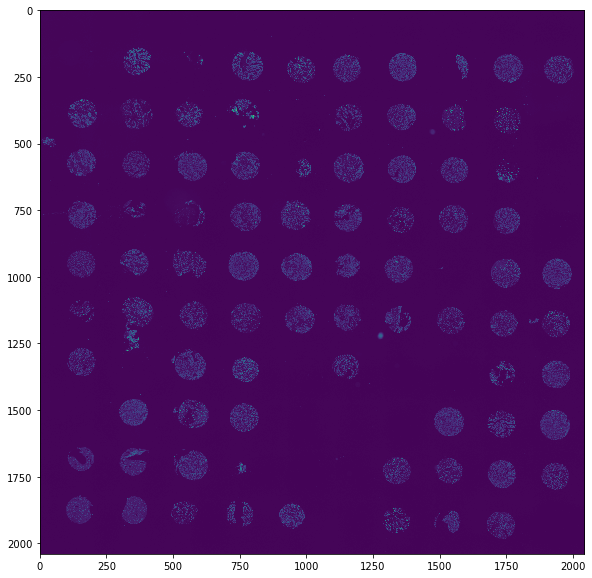

In [39]:
R0_dapi_name = parsed_names3[(parsed_names3.color_channel == 'c1') & (parsed_names3['round'] == 'R0')]

R0_dapi_full = imgs[R0_dapi_name.original.item()]
R0_dapi = R0_dapi_full[::config.downsample_proportion,::config.downsample_proportion]

print('shape of downsampled R0:', R0_dapi.GetSize())

plt.figure(figsize=(10,10))
plt.imshow(sitk.GetArrayViewFromImage(R0_dapi))
plt.show()

rescaling img..
applying gaussing blur...
otsu thresholding...


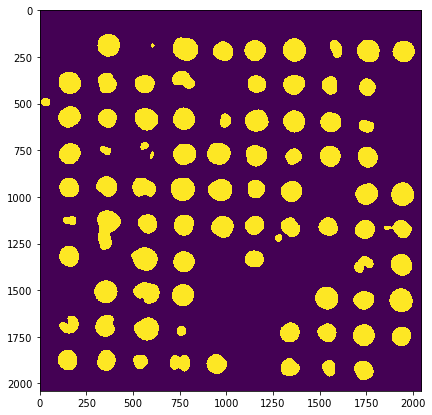

watershed threshold...


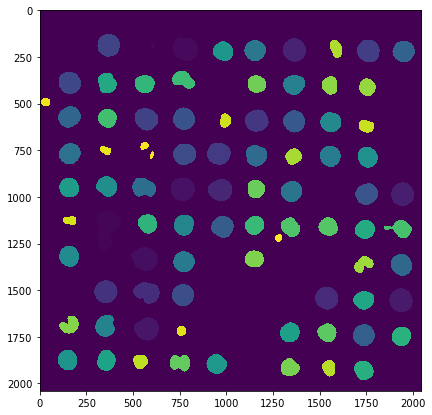

CPU times: user 4.69 s, sys: 36.1 ms, total: 4.73 s
Wall time: 2.07 s


,center_x,center_y,width,height,Volume (nm^3),Elongation,Flatness,Oriented Bounding Box Minimum Size(nm),Oriented Bounding Box Maximum Size(nm),Intensity Mean,Intensity Standard Deviation,Intensity Skewness
1,305,1072,127,213,0.747989,2.017365,2.017365,0.836918,1.396610,20.460291,24.616638,2.083258
2,592,147,255,125,0.590820,1.459442,1.459442,0.797697,1.669621,20.950372,21.948862,1.454599
3,489,1269,140,126,0.567752,1.146380,1.146380,0.801223,0.943005,20.466959,15.811597,0.801973
4,699,897,130,126,0.546289,1.027102,1.027102,0.820632,0.846054,21.145244,14.588854,0.454392
5,502,1646,134,124,0.530403,1.097005,1.097005,0.803420,0.872923,20.620679,15.798404,0.970800


In [113]:
%%time
R0_dapi_stats, shape_stats = segment.segment_dapi_round(R0_dapi, plot=True)
R0_dapi_stats.head()

# Choose core 

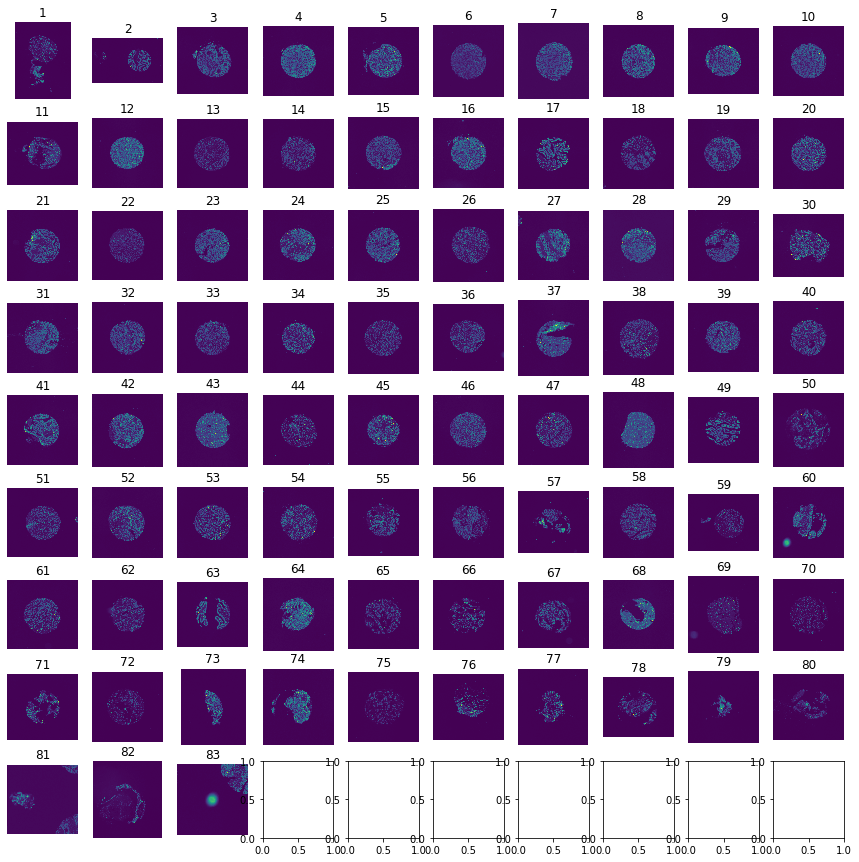

In [114]:
segment.plot_cores(R0_dapi, shape_stats)

which core would you like to use? (integer):  12
you chose:  12


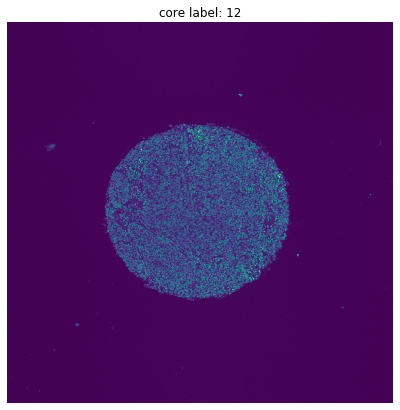

In [115]:
core_in = int(input('which core would you like to use? (integer):  '))
print('you chose: ', core_in)

R0_dapi_core = segment.select_core(R0_dapi_full, core_in, shape_stats, scale=config.downsample_proportion)

utils.myshow(R0_dapi_core, f'core label: {core_in}')

# match core labels across rounds 

In [116]:
%%time
dapi_names = parsed_names3[(parsed_names3.color_channel == 'c1')]

res = []

for name in dapi_names.original.values: 
    
    print('processing: ', name)
    dapi = imgs[name][::config.downsample_proportion,::config.downsample_proportion]
    dapi_stats, shape_stats = segment.segment_dapi_round(dapi)
    
    dapi_stats = dapi_stats.assign(img_name= name)
    res.append(dapi_stats)
    
res = pd.concat(res, axis=0)

processing:  R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_c1_ORG.tif
processing:  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG.tif
processing:  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13485-Scene-1_c1_ORG.tif
CPU times: user 13.3 s, sys: 373 ms, total: 13.6 s
Wall time: 5.57 s


plotting centers:  R0_AF488.AF555.AF647.AF750_S3_2020_01_21__13471-Scene-1_c1_ORG.tif
plotting centers:  R2_PCNA.AR.ER.GATA3_S3_2020_01_23__13492-Scene-1_c1_ORG.tif
plotting centers:  R1_H3K27me3.CCNB1.CCND1.Ki67_S3_2020_01_22__13485-Scene-1_c1_ORG.tif


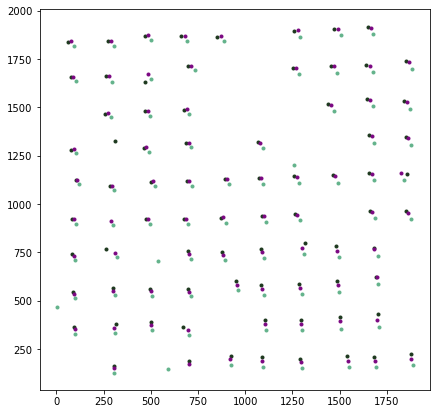

In [117]:
plt.figure(figsize=(7,7))

for i, name in enumerate(dapi_names.original.values):
    print('plotting centers: ', name)
    rgb = np.random.rand(3)
    temp = res[res.img_name == name]
    plt.plot(temp.center_x, temp.center_y, c=rgb, marker='.', linestyle='None')
    
plt.show()

In [119]:
# number of labels in R0_dapi - use this for the # of clusters (k)
k = R0_dapi_stats.shape[0]

feats = ['center_x', 'center_y', 'width', 'height']

X = res[feats].values

# initial cluster seeds will be R0 centers 
seeds = R0_dapi_stats[feats].values

clus = KMeans(n_clusters=k, init=seeds)
_ = clus.fit( X )

res = res.assign(cluster = clus.labels_)

/home/exacloud/lustre1/NGSdev/evansna/external/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: Explicit initial center position passed: performing only one init in k-means instead of n_init=10
  if sys.path[0] == '':


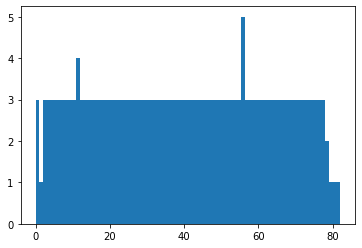

In [120]:
plt.figure()
plt.hist(clus.labels_, bins=len(np.unique(clus.labels_)))
plt.show()

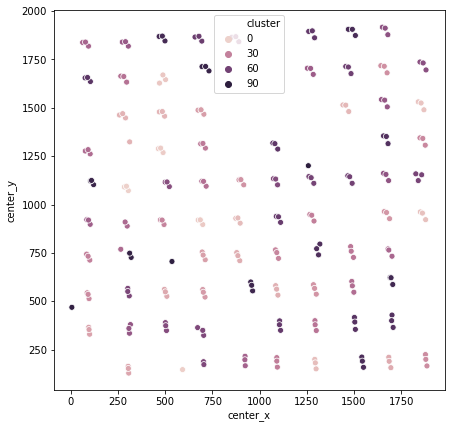

In [121]:
plt.figure(figsize=(7,7))
sbn.scatterplot(x='center_x', y='center_y', hue='cluster', data=res)
plt.show()

## remove clusters with too many regions

In [127]:
unique, cnts = np.unique(clus.labels_, return_counts=True)

In [130]:
toobig = unique[cnts > dapi_names.original.unique().shape[0]]
toosmol = unique[cnts < dapi_names.original.unique().shape[0]]
print('clusters with too many components:', toobig)
print('clusters with too few components:', toosmol)

clusters with too many components: [11 56]
clusters with too few components: [ 1 79 80 81 82]


In [131]:
clus.cluster_centers_

array([[ 294.66666667, 1086.        ,  123.33333333,  207.        ],
       [ 592.        ,  147.        ,  255.        ,  125.        ],
       [ 476.33333333, 1283.33333333,  139.        ,  126.33333333],
       [ 686.66666667,  912.66666667,  131.        ,  126.33333333],
       [ 486.66666667, 1648.        ,  143.66666667,  137.        ],
       [1855.        , 1515.33333333,  123.        ,  126.33333333],
       [1864.        ,  946.66666667,  124.33333333,  128.33333333],
       [1295.33333333,  177.66666667,  121.        ,  123.33333333],
       [ 885.33333333,  921.33333333,  132.66666667,  118.33333333],
       [1456.33333333, 1503.33333333,  125.        ,  121.66666667],
       [ 483.66666667, 1472.33333333,  140.33333333,  113.33333333],
       [ 283.75      , 1426.25      ,  117.25      ,  115.75      ],
       [1090.66666667,  558.66666667,  123.33333333,  114.        ],
       [ 886.33333333,  732.66666667,  126.        ,  119.33333333],
       [1688.33333333,  186.      